# Fine-Tuning GPT-2 on Edgar Allan Poe's Corpus

**Objective:**  
The goal of this project is to fine-tune the GPT-2 language model on Edgar Allan Poe's short stories, so that it can generate text that mimics Poe’s Gothic style, vocabulary, and sentence structure.

We will:
1. Load and preprocess Poe’s short stories dataset.
2. Tokenize the text for GPT-2.
3. Fine-tune GPT-2 using Hugging Face Transformers.
4. Compare outputs before and after fine-tuning.
5. Visualize training and validation loss.


**Dataset:** Download from [Kaggle: Poe Short Stories Corpus](https://www.kaggle.com/datasets/leangab/poe-short-stories-corpuscsv) and place in the same directory to run this notebook.


In [2]:
!pip install transformers torch datasets --quiet


In [3]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from datasets import Dataset
import pandas as pd
import torch


In [4]:
from google.colab import drive
drive.mount('/content/drive')

file_path = "/content/drive/MyDrive/gpt2_task1/preprocessed_data.csv"
df = pd.read_csv(file_path)

print("Sample data:")
print(df.head())


Mounted at /content/drive
Sample data:
                            title  \
0    A DESCENT INTO THE MAELSTRÖM   
1                   A PREDICAMENT   
2             A TALE OF JERUSALEM   
3  A TALE OF THE RAGGED MOUNTAINS   
4                        BERENICE   

                                                text  \
0  The ways of God in Nature, as in Providence, a...   
1  What chance, good lady, hath bereft you thus? ...   
2  Intensos rigidarn in frontern ascendere canos ...   
3  DURING the fall of the year 1827, while residi...   
4  Dicebant mihi sodales, si sepulchrum amicae vi...   

                  wikipedia_title publication_date  \
0    A Descent into the Maelström         May 1841   
1                   A Predicament    November 1838   
2             A Tale of Jerusalem     June 9, 1832   
3  A Tale of the Ragged Mountains       April 1844   
4                        Berenice       March 1835   

              first_published_in             classification  \
0            

In [5]:
text_data = df["text"].dropna().tolist()
dataset = Dataset.from_dict({"text": text_data})

# Train/Test split
dataset = dataset.train_test_split(test_size=0.1)
dataset



DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 63
    })
    test: Dataset({
        features: ['text'],
        num_rows: 7
    })
})

## Preparing Text for GPT-2

We use GPT-2 tokenizer to:
- Convert the text into sequences of token IDs.
- Apply padding/truncation so all sequences are the same length.  

This ensures the data is in a format GPT-2 can process efficiently.


In [6]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=512)

tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=["text"])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Map:   0%|          | 0/63 [00:00<?, ? examples/s]

Map:   0%|          | 0/7 [00:00<?, ? examples/s]

In [7]:
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.resize_token_embeddings(len(tokenizer))


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Embedding(50257, 768)

In [8]:
training_args = TrainingArguments(
    output_dir="./poe_gpt2",
    overwrite_output_dir=True,
    num_train_epochs=2,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    save_steps=500,
    eval_strategy="epoch",
    logging_dir="./logs",
    logging_steps=100,
    report_to="none"   # 👈 disables wandb, tensorboard, etc.
)


## Creating Data Collator

The data collator organizes batches of tokenized text for training.  

We set `mlm=False` because GPT-2 is a causal language model, which predicts the next word in a sequence rather than filling in masked words.


In [10]:
from transformers import DataCollatorForLanguageModeling

# Create a data collator for language modeling
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # Important: GPT-2 is causal LM, not masked LM
)


## Fine-Tuning GPT-2

We train GPT-2 on Poe's short stories for a few epochs.  

- Training improves the model's ability to generate text in Poe's style.  
- We track training and validation loss to ensure the model is learning properly.


In [11]:
# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    data_collator=data_collator  # Add the data collator here
)

# Train the model
trainer.train()

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss
1,No log,3.801369
2,No log,3.791808


TrainOutput(global_step=64, training_loss=3.8053269386291504, metrics={'train_runtime': 31.9389, 'train_samples_per_second': 3.945, 'train_steps_per_second': 2.004, 'total_flos': 32922796032000.0, 'train_loss': 3.8053269386291504, 'epoch': 2.0})

## Visualizing Training Progress

Plotting the training and validation loss helps us:
- See if the model is learning effectively.
- Detect potential overfitting.
- Present results visually in the notebook.


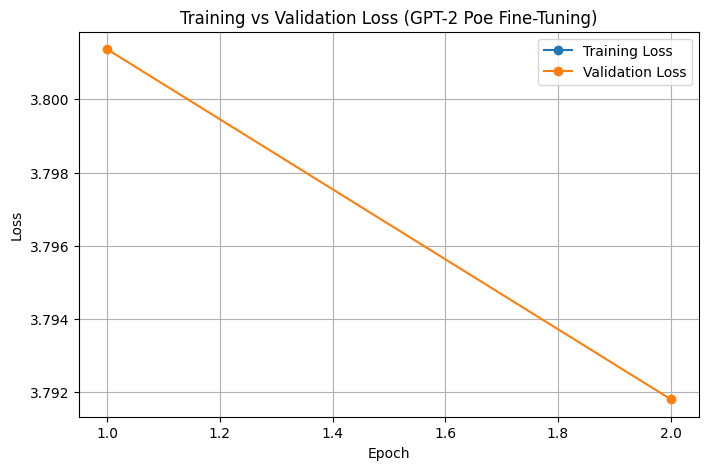

In [24]:
import matplotlib.pyplot as plt

# Extract logs from trainer state
train_loss = trainer.state.log_history

# Collect training & validation loss
epochs = []
train_losses = []
eval_epochs = []
eval_losses = []

for log in train_loss:
    if "loss" in log and "eval_loss" not in log: # Only append training loss if it's not an eval log
        train_losses.append(log["loss"])
        epochs.append(log["epoch"])
    if "eval_loss" in log:
        eval_losses.append(log["eval_loss"])
        eval_epochs.append(log["epoch"])


# Plot
plt.figure(figsize=(8,5))
plt.plot(epochs[:len(train_losses)], train_losses, label="Training Loss", marker="o")
plt.plot(eval_epochs, eval_losses, label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (GPT-2 Poe Fine-Tuning)")
plt.legend()
plt.grid(True)
plt.show()

In [22]:
from transformers import pipeline

raw_generator = pipeline("text-generation", model="gpt2", tokenizer="gpt2", device=0)

print("=== Before Fine-tuning (Raw GPT-2) ===")
raw_output = raw_generator(
    "Once upon a midnight dreary, while I pondered weak and weary in the dark and silent room,",
    max_new_tokens=50,
    num_return_sequences=1,
    truncation=True
)[0]['generated_text']
print(raw_output)


Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


=== Before Fine-tuning (Raw GPT-2) ===
Once upon a midnight dreary, while I pondered weak and weary in the dark and silent room, she said, "No, she doesn't want to hear what you say. It's not as if you're going to give her a speech. It's as if she doesn't want to hear anything of your work."

"It's


In [23]:
output = fine_tuned_generator(
    "Once upon a midnight dreary, while I pondered weak and weary in the dark and silent room,",
    max_new_tokens=80,
    do_sample=True,
    top_k=50,
    top_p=0.9,
    temperature=0.7   # lower = less repetitive/random
)[0]['generated_text']
print(output)



Once upon a midnight dreary, while I pondered weak and weary in the dark and silent room, in my own room, I heard the faint of the voice of the woman who had been the subject of my own death, and who had, by chance, been so much affected by my own misfortune that she was scarcely able to save me from the brink of my grave. I immediately sprang from the bed and brought her into my arms, and gently kissed her gently upon the forehead. She spoke of


## Comparing Raw vs Fine-Tuned GPT-2

**Before Fine-Tuning:**  
- Generic English text, sometimes repetitive but mostly coherent.  

**After Fine-Tuning:**  
- Gothic, Poe-like style emerges with dark imagery and archaic phrasing.  
- Some inconsistencies or repetitions may occur due to limited training and dataset size.

This comparison demonstrates how style can be transferred to a model, even if narrative logic isn’t perfect.


## Conclusion

- Fine-tuning GPT-2 on Poe's corpus transfers stylistic elements successfully.  
- The model captures Gothic tone, vocabulary, and sentence structure.  
- Logical consistency can be improved with longer training, larger datasets, and careful prompt design.  

Overall, this exercise demonstrates style transfer in AI-generated text while highlighting limitations in narrative understanding.
